### Importing Libraries

In [ ]:
import pandas as pd
import pmdarima as pm
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

## Load Data

In [ ]:
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')
exc_returns = pd.read_pickle('data/exc_returns.pkl')
prices_tukey = pd.read_pickle('data/tukey_estimates.pkl')
index_returns = pd.read_pickle("data/index_returns.pkl")

In [ ]:
index_returns

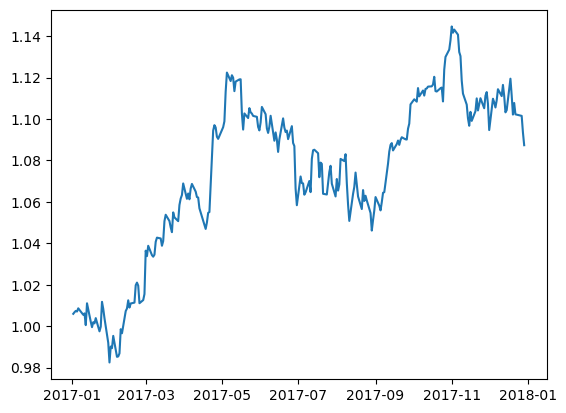

In [12]:
index_perf = (1 + index_returns.loc['2017-01-02':'2017-12-31']).cumprod()

plt.plot(index_perf);

## Baseline MODELS

### ARIMA

In [ ]:
#split data into train and training set
train_price, test_price = prices_tukey.loc[:'2018-12-01'], prices_tukey.loc['2018-12-01':]

In [ ]:
predictions = {}
for_period = len(test_price)

for stock in train_price.columns:
    # m = 1 -> m = frequency (1 = daily)
    # auto p,d,q and auto differencing
    model = pm.auto_arima(train_price[stock], m=1, seasonal=False, suppress_warnings=True)
    
    pred = model.predict(n_periods = for_period)
    pred = pd.Series(pred)

    predictions[stock] = pred

In [ ]:
preds = pd.DataFrame()

for stock in predictions.keys():
    preds[stock] = predictions[stock].values

preds.index = test_price.index

In [ ]:
display(preds)

#### Workflow

In [ ]:
preds_returns = np.log(preds / preds.shift(1)).dropna()
preds_returns

r1, r2, r3

(1 + r1) ... (1+r3)

1 * (1+r1) * (1 + r2) * ... * (1+rn) = 1,13 (e.g.)

rtot (from 1 to n) = 1,13 - 1  

In [ ]:
pred_performance_ARIMA = (1 + preds_returns).prod() - 1
print(pred_performance_ARIMA)

In [ ]:
pred_performance_ARIMA.sort_values(ascending=False)

In [ ]:
choices = pred_performance_ARIMA.sort_values(ascending=False).index[:7]

-------

In [ ]:
test_exc_ret = exc_returns.loc['2018-12-03':][choices]

In [ ]:
cum_exc_returns_choices = (1 + test_exc_ret[choices]).prod() - 1
print(cum_exc_returns_choices)

In [ ]:
# Calculate the performance of the portfolio (equal weight on my preselected stocks)

sum(cum_exc_returns_choices * (1/7))

Since the weighted average with weight 1/N of the excess returns of the top 7 stocks selected by the ARIMA model is NEGATIVE, the alpha of our portfolio is negative hence this strategy underperforms the SX5E index performance; for the period considered. 

#### Functions

In [ ]:
def get_ranking(predictions, N : list, prices : bool):

    # Considering the df of predictions:
    # 1) Calculate the cumulative returns for each stock (for the considered period)
    # 2) Calculate the ranking in descending order for the cumulative returns 
    # 3) Select the top stocks among the ranking (for all top Ns)

    if prices:
       returns = np.log(predictions / predictions.shift(1)).dropna()

       cum_returns = (1 + returns).prod() - 1
    
    else:
        cum_returns = (1 + predictions).prod() - 1

    ranking = cum_returns.sort_values(ascending=False).index

    portfolios = {}

    for i in N:
        portfolios[f'Top{i}'] = list(ranking[:i])

    # Return 4 lists with names of the top stocks according to the model's ranking
    # basically the stocks composing each portfolio with N stocks
       
    return portfolios

In [ ]:
portfolios_ARIMA = get_ranking(preds, N = [5, 7, 10], prices=True)

In [ ]:
tot_performance_ARIMA, portfolio_series_ARIMA = calc_portfolios(portfolios_ARIMA, stocks_returns.loc[preds.index[0]:])

In [ ]:
tot_performance_ARIMA

In [ ]:
def plot_portfolios(portfolios_series : dict, index_ret):

    index_perf = (1 + index_ret).cumprod()

    plt.figure(figsize=(16, 9))
    plt.plot(index_perf, label = 'SX5E performance')

    for key, value in portfolios_series.items():

        portfolio_perf = (1 + value).cumprod()

        plt.plot(portfolio_perf, label = key)
    
    plt.legend()
    plt.show()

In [ ]:
plot_portfolios(portfolio_series_ARIMA, index_returns.loc[preds.index[0]:])

## Models